In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2/detectron2'))
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 9.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15743, done.
remote: Total 15743 (delta 0), reused 0 (delta 0), pack-reused 15743
Receiving objects: 100% (15743/15743), 6.31 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (11496/11496), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing meta

In [ ]:
import os
os.chdir('/content/mydata')
os.listdir()

['output', 'val', '.ipynb_checkpoints', 'train']

In [ ]:
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
def get_dicts(img_dir,d):
    json_file = os.path.join(img_dir, "annotations.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns["images"]):
        record = {}
        filename = os.path.join(img_dir, v["file_name"])
        height, width = v["height"], v["width"]
        record["file_name"] =filename
        record["image_id"] = v["id"]
        record["height"] = height
        record["width"] = width
        annos = [anno for anno in imgs_anns["annotations"] if anno["image_id"] == v["id"]]
        objs = []
        for anno in annos:
            obj = {
                "bbox": anno["bbox"],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": anno["category_id"]-1,
                "iscrowd": anno.get("iscrowd", 0)
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
for d in ["train","val"]:
    DatasetCatalog.register("my_data_" + d, lambda d=d: get_dicts(f"{d}/",d))
    MetadataCatalog.get("my_data_" + d).set(thing_classes=["damaged"])

metadata = MetadataCatalog.get("my_data_train")

In [ ]:
# Configuration
import torch
assert torch.cuda.is_available(), "Make sure to enable GPU in Runtime > Change runtime type"

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_data_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 12
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR='/content/mydata/output'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/29 20:22:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:02, 104MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[07/29 20:22:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/29 20:22:58 d2.utils.events]:  eta: 0:18:17  iter: 19  total_loss: 7.287  loss_cls: 0.5668  loss_box_reg: 0.02027  loss_rpn_cls: 5.329  loss_rpn_loc: 1.074    time: 0.7807  last_time: 0.6807  data_time: 0.2999  last_data_time: 0.2122   lr: 4.9953e-06  max_mem: 2403M
[07/29 20:23:18 d2.utils.events]:  eta: 0:18:06  iter: 39  total_loss: 4.354  loss_cls: 0.5532  loss_box_reg: 0.1295  loss_rpn_cls: 2.503  loss_rpn_loc: 1.124    time: 0.7902  last_time: 0.7556  data_time: 0.2937  last_data_time: 0.2572   lr: 9.9902e-06  max_mem: 2403M
[07/29 20:23:35 d2.utils.events]:  eta: 0:18:11  iter: 59  total_loss: 2.042  loss_cls: 0.5408  loss_box_reg: 0.2588  loss_rpn_cls: 0.3887  loss_rpn_loc: 0.8953    time: 0.8047  last_time: 1.0266  data_time: 0.3260  last_data_time: 0.4835   lr: 1.4985e-05  max_mem: 2406M
[07/29 20:23:54 d2.utils.events]:  eta: 0:18:33  iter: 79  total_loss: 1.777  loss_cls: 0.5179  loss_box_reg: 0.2891  loss_rpn_cls: 0.3241  loss_rpn_loc: 0.625    time: 0.8439  last_time:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this mode
cfg.DATASETS.TEST = ("my_data_val", )
predictor = DefaultPredictor(cfg)

[07/29 20:44:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/mydata/output/model_final.pth ...


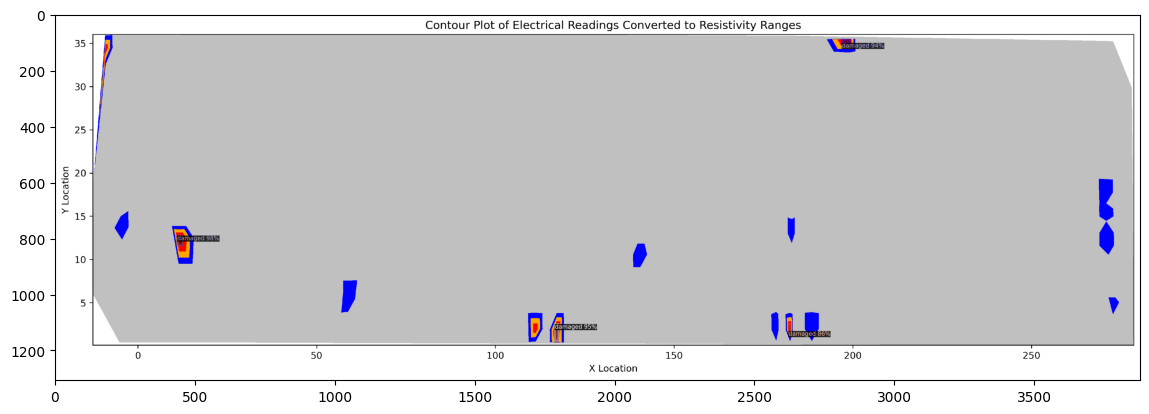

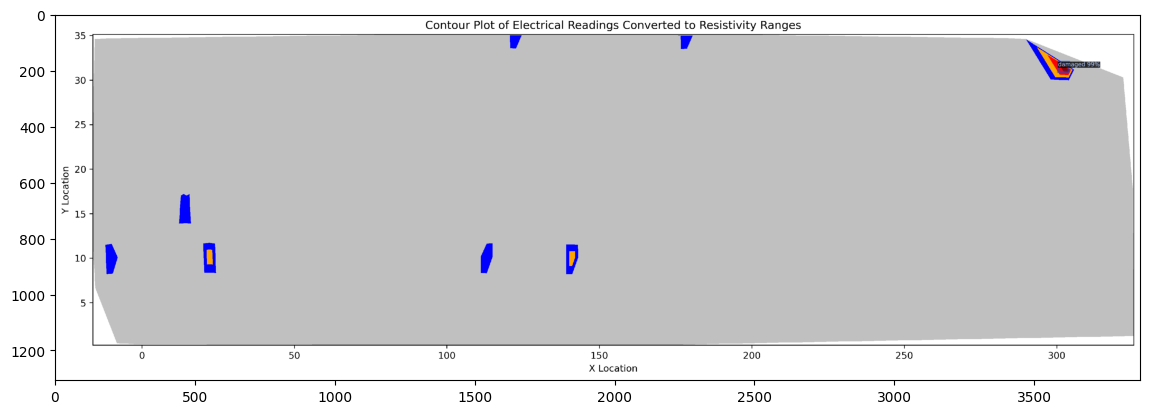

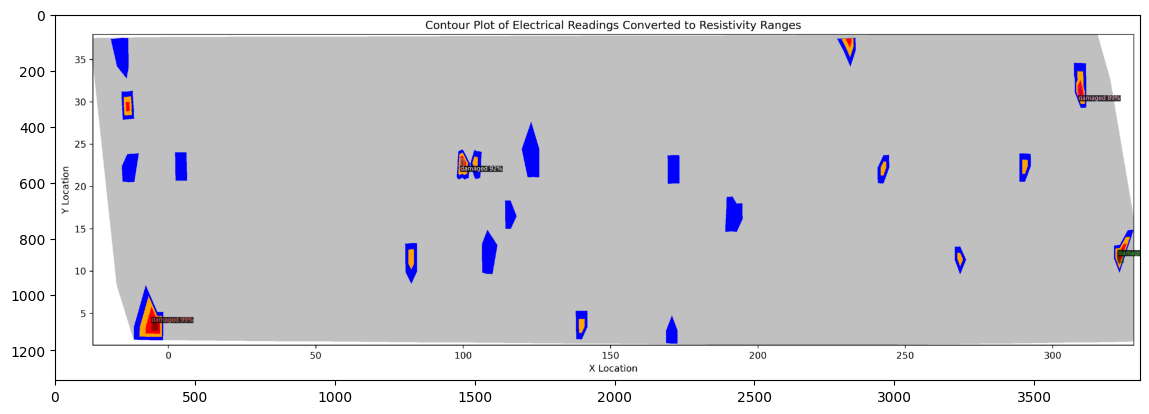

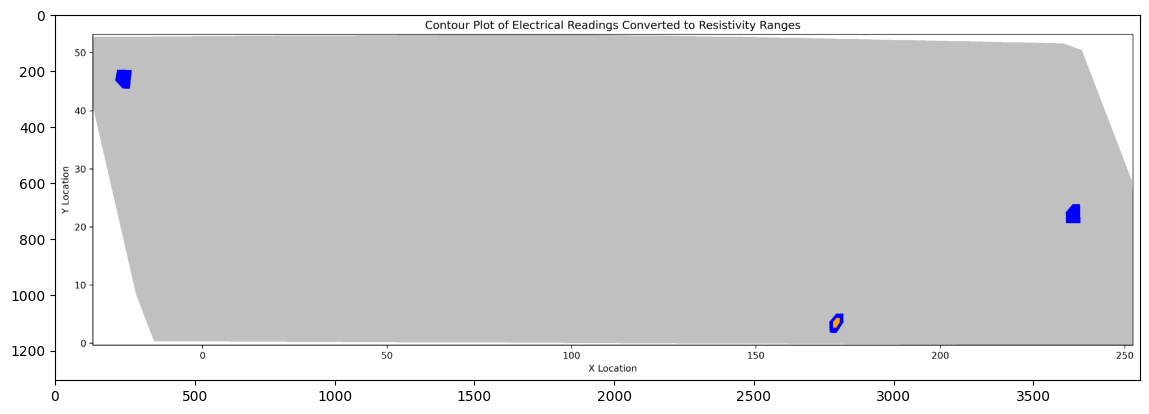

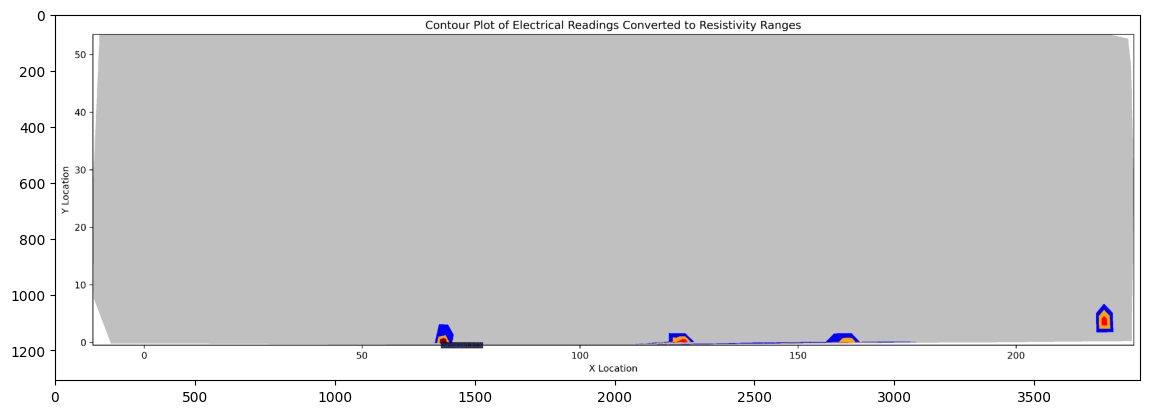

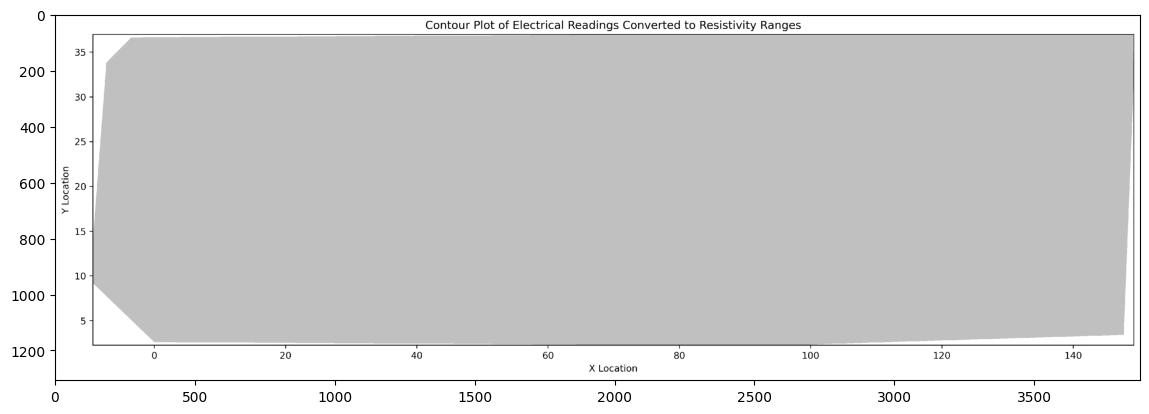

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random
import matplotlib.pyplot as plt
dataset_dicts = get_dicts("val/","val")
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# Create the evaluator and run the evaluation
evaluator = COCOEvaluator("my_data_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "my_data_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[07/25 15:19:32 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [07/25 15:19:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/25 15:19:32 d2.evaluation.coco_evaluation]: Trying to convert 'my_data_val' to COCO format ...
[07/25 15:19:32 d2.data.datasets.coco]: Converting annotations of dataset 'my_data_val' to COCO format ...)
[07/25 15:19:32 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/25 15:19:32 d2.data.datasets.coco]: Conversion finished, #images: 6, #annotations: 10
[07/25 15:19:32 d2.data.datasets.coco]: Caching COCO format annotations at '/content/mydata/output/my_data_val_coco_format.json' ...
[07/25 15:19:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  damaged   | 10           |
|            |              |
[07

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/25 15:19:35 d2.evaluation.evaluator]: Total inference time: 0:00:00.155741 (0.155741 s / iter per device, on 1 devices)
[07/25 15:19:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.101953 s / iter per device, on 1 devices)
[07/25 15:19:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/25 15:19:35 d2.evaluation.coco_evaluation]: Saving results to /content/mydata/output/coco_instances_results.json
[07/25 15:19:35 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.885
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 

OrderedDict([('bbox',
              {'AP': 44.8827926270888,
               'AP50': 88.46319414550155,
               'AP75': 28.38283828382838,
               'APs': 38.492456388495995,
               'APm': 58.91089108910891,
               'APl': nan})])

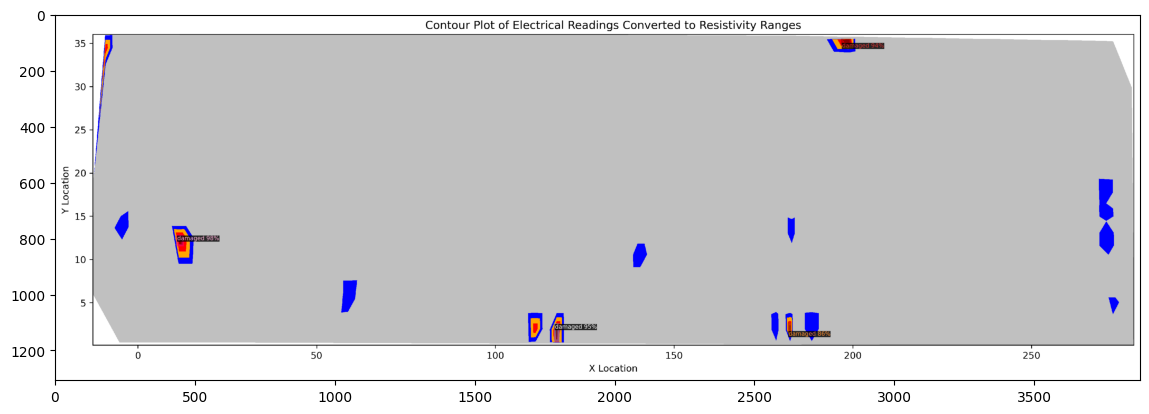

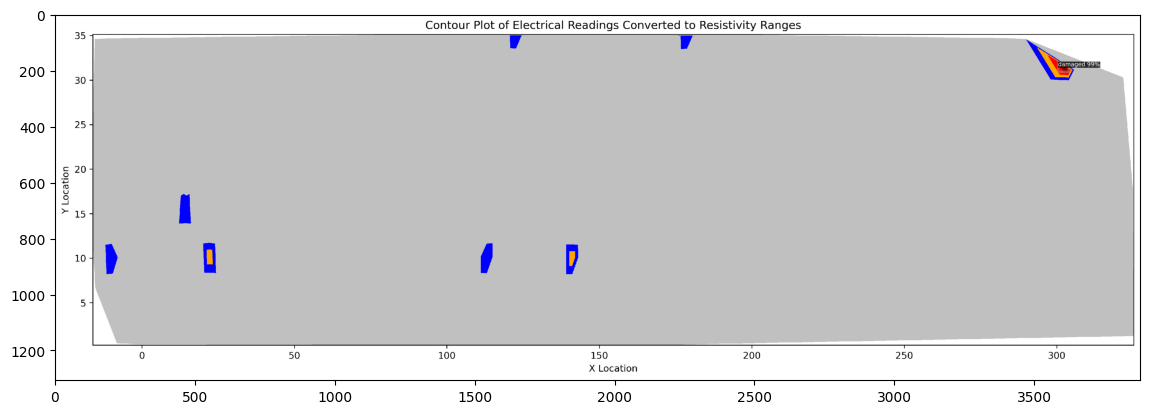

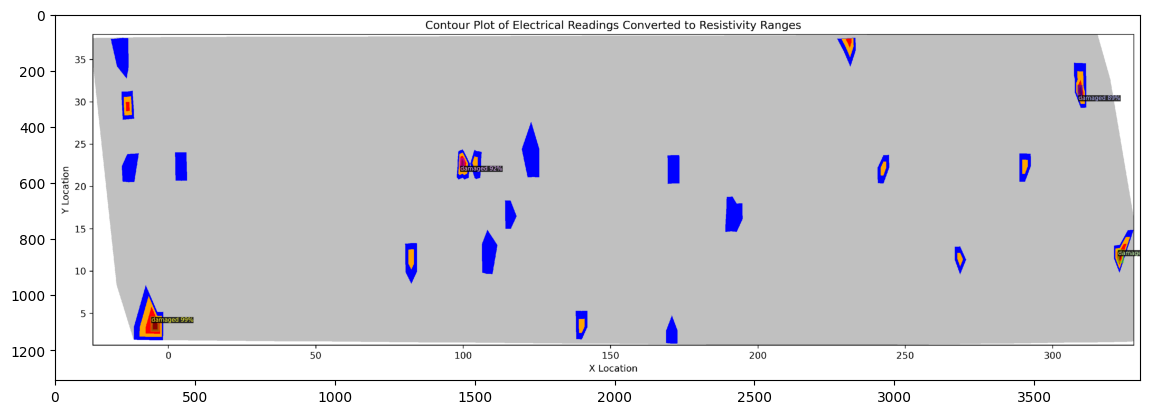

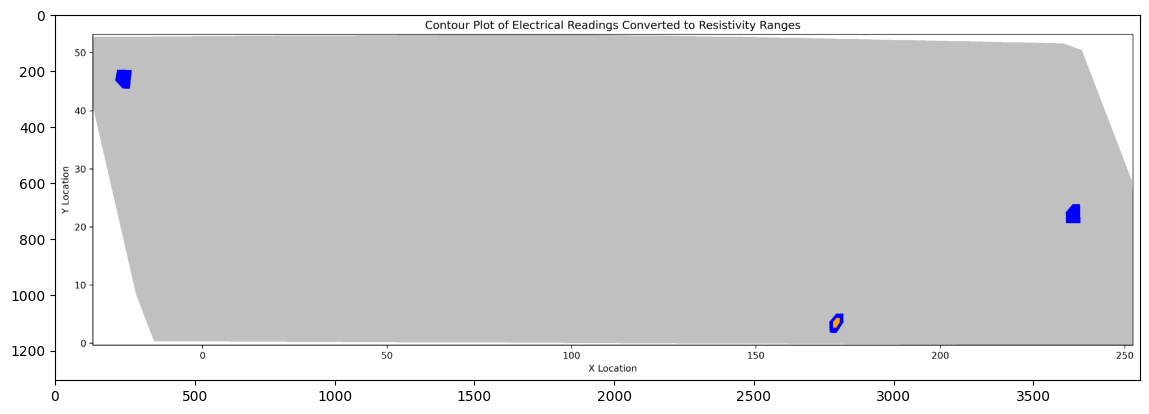

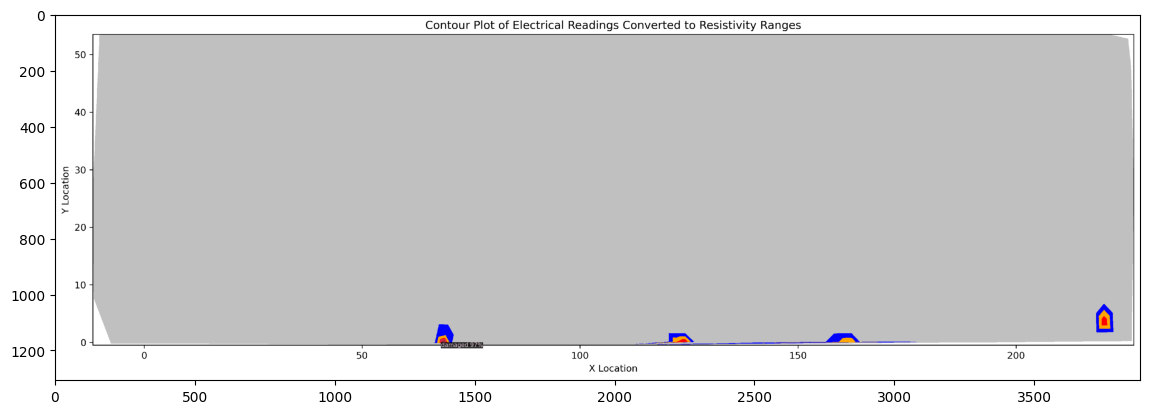

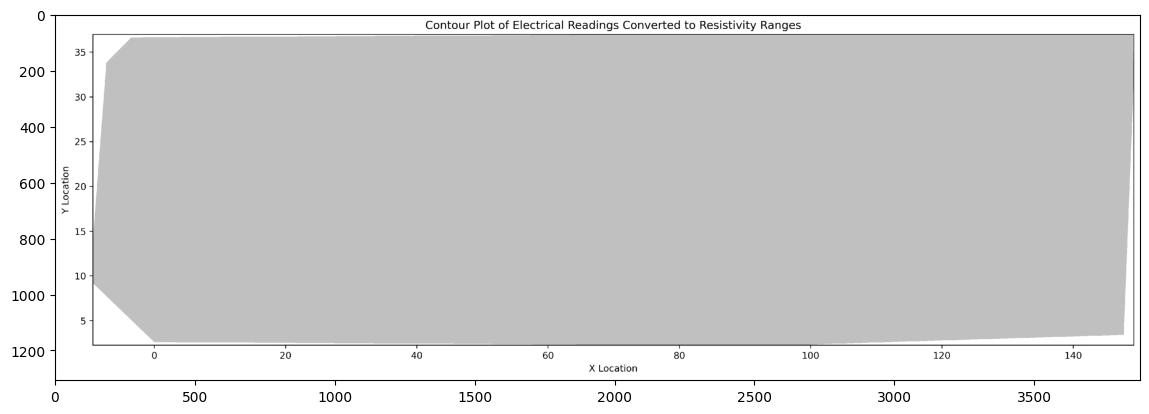

In [ ]:
import os
import sys
import distutils.core
import json
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

def convert_to_py_types(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    return obj

# Function to extract contours and save to a JSON file
def extract_and_save_contours(img_dir, dataset_dicts, output_file):
    output_data = []
    for d in dataset_dicts:
        record = {}
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes.tensor.numpy()
        scores = instances.scores.numpy()
        classes = instances.pred_classes.numpy()

        record["BridgeID"] = d["image_id"]
        record["BridgeName"] = os.path.basename(d["file_name"])
        record["Length"] = convert_to_py_types(d["height"])
        record["Width"] = convert_to_py_types(d["width"])
        record["TotalNumOfContours"] = convert_to_py_types(len(boxes))
        record["Contours"] = []

        for i, box in enumerate(boxes):
            contour = {
                "Line_ID": convert_to_py_types(i),
                "NumOfPoints": 4,  # A bounding box has 4 points
                "CorrosionDegree": convert_to_py_types(scores[i]),
                "Points": [
                    {"x": convert_to_py_types(box[0]), "y": convert_to_py_types(box[1])},
                    {"x": convert_to_py_types(box[2]), "y": convert_to_py_types(box[1])},
                    {"x": convert_to_py_types(box[2]), "y": convert_to_py_types(box[3])},
                    {"x": convert_to_py_types(box[0]), "y": convert_to_py_types(box[3])}
                ]
            }
            record["Contours"].append(contour)

        output_data.append(record)

    with open(output_file, 'w') as f:
        json.dump(output_data, f, indent=4)

# Define paths and extract contours
output_file = '/content/mydata/output/contours.json'
dataset_dicts = get_dicts("val/", "val")
extract_and_save_contours("val/", dataset_dicts, output_file)

# Visualize predictions
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()